In [1]:
# Indexing is the process of preparing and organizing data (like documents, web pages, or text chunks) so that it can be efficiently searched and retrieved later.

In [2]:
from dotenv import load_dotenv

load_dotenv()  # load environment variables

True

### Problem Statement

RAG systems rely on effective indexing. Weak indexing can bury relevant content, omit key context, or fragment meaning‚Äîleading to incomplete or misleading results.

**Example:**

User query:
- "How do I reset my password?"

Problem:
- The document containing the answer says: ‚ÄúClick ‚ÄòForgot Password‚Äô on the login screen.‚Äù
- But the phrase ‚Äúreset your password‚Äù doesn't appear anywhere in the text.

Potential bad outcome:
- The retriever misses the relevant document.
- The LLM responds: ‚ÄúSorry, I couldn‚Äôt find anything about that,‚Äù even though the answer exists in the corpus.

### Strategy #1: Chunking Optimization

**Idea**:

[Chucking Visualizer](https://chunkviz.up.railway.app/)

In [3]:
# Do setup for chunking optimization here

from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter, MarkdownTextSplitter, \
    PythonCodeTextSplitter, Language

small_text = "This is the text I would like to chunk up. It is the example text for this exercise"
big_text = """
What is Lorem Ipsum?

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Why do we use it?

It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout. The point of using Lorem Ipsum is that it has a more-or-less normal distribution of letters, as opposed to using 'Content here, content here', making it look like readable English. Many desktop publishing packages and web page editors now use Lorem Ipsum as their default model text, and a search for 'lorem ipsum' will uncover many web sites still in their infancy. Various versions have evolved over the years, sometimes by accident, sometimes on purpose (injected humour and the like).
"""
markdown_text = """
# Fun in California

## Driving

Try driving on the 1 down to San Diego

### Food

Make sure to eat a burrito while you're there

## Hiking

Go to Yosemite
"""
python_text = """
class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age

p1 = Person("John", 36)

for i in range(10):
    print(i)
"""

#### Chunking Strategy #1: Character-Level

**Character splitting** simply divides the text into **N-character sized chunks** regardless of their content or form. This is the most basic form of splitting up text.

In [4]:
# Let's trivially chunk the text ourselves

chunks = []
chunk_size = 35  # Characters

for i in range(0, len(small_text), chunk_size):
    chunk = small_text[i:i + chunk_size]
    chunks.append(chunk)

chunks

['This is the text I would like to ch',
 'unk up. It is the example text for ',
 'this exercise']

In [5]:
# We can also use LangChain's CharacterTextSplitter to achieve the same thing

text_splitter = CharacterTextSplitter(chunk_size=35, chunk_overlap=0, separator='', strip_whitespace=False)
docs = text_splitter.create_documents([small_text])

list(map(lambda doc: doc.page_content, docs))

['This is the text I would like to ch',
 'unk up. It is the example text for ',
 'this exercise']

In [6]:
# With LangChain, we can also specify the chunk overlap, which is the amount we'd like our sequential
# chunks to overlap. This helps preserve context between adjacent chunks.

text_splitter = CharacterTextSplitter(chunk_size=35, chunk_overlap=5, separator='', strip_whitespace=False)
docs = text_splitter.create_documents([small_text])

list(map(lambda doc: doc.page_content, docs))

['This is the text I would like to ch',
 'to chunk up. It is the example text',
 ' text for this exercise']

#### Chunking Strategy #2: Character-Level

**Recursive character splitting** breaks the text into smaller chunks *recursively*, based on a *prioritized list of separators.*

It tries to split the text using a list of delimiters (like `"\n\n"`, `"\n"`, `"."`, `" "`, etc.), starting from the *largest* logical unit (like paragraphs) and falling back to smaller ones (like sentences or words) *only if needed*.

In [7]:
# Let's try out RecursiveCharacterTextSplitter in LangChain. Note that:
#  - We no longer break words
#  - We break paragraphs
#  - We still break on sentences, which messes with semantics

text_splitter = RecursiveCharacterTextSplitter(chunk_size=65, chunk_overlap=0)
docs = text_splitter.create_documents([big_text])

list(map(lambda doc: doc.page_content, docs))

['What is Lorem Ipsum?',
 'Lorem Ipsum is simply dummy text of the printing and typesetting',
 "industry. Lorem Ipsum has been the industry's standard dummy",
 'text ever since the 1500s, when an unknown printer took a galley',
 'of type and scrambled it to make a type specimen book. It has',
 'survived not only five centuries, but also the leap into',
 'electronic typesetting, remaining essentially unchanged. It was',
 'popularised in the 1960s with the release of Letraset sheets',
 'containing Lorem Ipsum passages, and more recently with desktop',
 'publishing software like Aldus PageMaker including versions of',
 'Lorem Ipsum.',
 'Why do we use it?',
 'It is a long established fact that a reader will be distracted',
 'by the readable content of a page when looking at its layout.',
 'The point of using Lorem Ipsum is that it has a more-or-less',
 "normal distribution of letters, as opposed to using 'Content",
 "here, content here', making it look like readable English. Many",
 'deskt

#### Chunking Strategy #3: Document Specific

Document-specific splitting tailors the chunking strategy based on the structure or format of the document type ‚Äî instead of using a one-size-fits-all method.

Different documents have different natural boundaries:
- PDFs ‚Üí pages or headers
- HTML ‚Üí tags like `<p>`, `<h1>`
- Markdown ‚Üí sections like `## Heading`, `` ```js ``, `---`
- JSON ‚Üí objects/arrays
- Code ‚Üí functions or classes

In [8]:
# Let's chunk Markdown text

text_splitter = MarkdownTextSplitter(chunk_size=40, chunk_overlap=0)
docs = text_splitter.create_documents([markdown_text])

list(map(lambda doc: doc.page_content, docs))

['# Fun in California\n\n## Driving',
 'Try driving on the 1 down to San Diego',
 '### Food',
 "Make sure to eat a burrito while you're",
 'there',
 '## Hiking\n\nGo to Yosemite']

In [9]:
# Let's chunk Python code

text_splitter = PythonCodeTextSplitter(chunk_size=100, chunk_overlap=0)
docs = text_splitter.create_documents([python_text])

list(map(lambda doc: doc.page_content, docs))

['class Person:\n    def __init__(self, name, age):\n        self.name = name\n        self.age = age',
 'p1 = Person("John", 36)\n\nfor i in range(10):\n    print(i)']

In [10]:
# We can do the same thing using RecursiveCharacterTextSplitter.from_language(...)

text_splitter = RecursiveCharacterTextSplitter.from_language(language=Language.PYTHON, chunk_size=100, chunk_overlap=0)
docs = text_splitter.create_documents([python_text])

list(map(lambda doc: doc.page_content, docs))

['class Person:\n    def __init__(self, name, age):\n        self.name = name\n        self.age = age',
 'p1 = Person("John", 36)\n\nfor i in range(10):\n    print(i)']

In [11]:
# We can chunk PDF files too using "unstructured".
#  - To start out, let's just pull all the tables out of a PDF.

from unstructured.partition.pdf import partition_pdf
from unstructured.documents.elements import Table

filename = "rsc/q1-report.pdf"
elements = partition_pdf(
    filename=filename,
    languages=["eng"],
    strategy="hi_res",
    infer_table_structure=True,
    model_name="yolox",
)
tables = [el for el in elements if isinstance(el, Table)]

tables[0].metadata.text_as_html

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


'<table><thead><tr><th>Revenue</th><th>$8.51 - $8.53 Billion</th><th>$34.5 - $34.7 Billion</th></tr></thead><tbody><tr><td>Y/Y Growth</td><td>~10%</td><td>~10%</td></tr><tr><td>FX Impact)</td><td>no impact</td><td>no impact</td></tr><tr><td>GAAP Operating Margin</td><td>N/A</td><td>~11.4%</td></tr><tr><td>Non-GAAP Operating Margin?)</td><td>N/A</td><td>~28.0%</td></tr><tr><td>GAAP Earnings per Share?)</td><td>$0.79 - $0.80</td><td>$2.67 - $2.69</td></tr><tr><td>Non-GAAP Earnings per Share()</td><td>$1.89 - $1.90</td><td>$7.41 - $7.43</td></tr><tr><td>Operating Cash Flow Growth (Y/Y)¬∞)</td><td>N/A</td><td>16% - 17%</td></tr><tr><td>Current Remaining Performance Obligation Growth (Y/Y)</td><td>~10%</td><td>N/A</td></tr></tbody></table>'

In [12]:
# By passing a few more flags, we can get unstructured to chunk multi-modal pdf data.
#  - We get back a list of CompositeElements, each one representing a multimodal chunk of our pdf.
#    - CompositeElements can contain text, tables, images, etc.
#  - All images from the pdf are extracted and stored in a folder for later reference.

raw_pof_elements = partition_pdf(
    filename="rsc/white-paper.pdf",
    languages=["eng"],
    extract_images_in_pdf=True,
    infer_table_structure=True,

    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir="rsc/out",
)

raw_pof_elements

In [13]:
# We can access a CompositeElement's ".metadata.orig_elements" to list the elements that make it up.
# We can use a CompositeElement's ".text" to get the concatenation of all text from its children.

composite_elem = raw_pof_elements[3]
orig_elements = composite_elem.metadata.orig_elements

orig_elements, composite_elem.text

([<unstructured.documents.elements.Title at 0x343f75ef0>,
 '3 GPT-assisted Visual Instruction Data Generation\n\nThe community has witnessed a surge in the amount of public multimodal data such as image-text pairs, ranging from CC [8] to LAION [45]. However, when it comes to multimodal instruction-\n\n2\n\nContext type 1: Captions\n\nA group of people standing outside of a black vehicle with various luggage. Luggage surrounds a vehicle in an underground parking area People try to fit all of their luggage in an SUV. The sport utility vehicle is parked in the public garage, being packed for a trip Some people with luggage near a van that is transporting it. Context type 2: Boxes person: [0.681, 0.242, 0.774, 0.694], backpack: [0.384, 0.696, 0.485, 0.914], suitcase: ...<omitted>')

'rsc/out/figure-3-1.jpg'

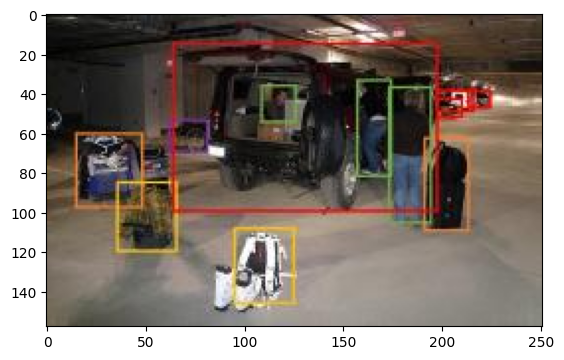

In [14]:
# Images are not included in the CompositeElement's ".text".
#   - To handle images, we can select them from ".metadata.orig_elements" and get things like "image_path" from them.
#   - From there, we can get embeddings from the images via:
#       - Passing the image to CLIP, which handles embedding both images and text.
#       - Generating a summary of the image and embedding that summary.
#           - There's an example of how to do this in "langchain_rag.ipynb"

from PIL import Image as PILImage
import matplotlib.pyplot as plt

image_path = orig_elements[-1].metadata.image_path
pil_img = PILImage.open(image_path)
plt.imshow(pil_img)

image_path

#### Chunking Strategy #4: Semantic

**Semantic splitting** breaks the text into meaningful units based on its *semantic content* (i.e., meaning), rather than using arbitrary rules like character count or number of sentences.

In [15]:
# Idea: use sentence embeddings to detect topic shifts.

# 1. Split text into sentences (e.g., with nltk.sent_tokenize or spaCy).
# 2. Convert each sentence (or small group of sentences) into embeddings using an embedding model.
# 3. Slide a window across sentence embeddings and compute cosine similarity between adjacent windows.
# 4. If similarity drops below a threshold, start a new chunk.

![Image](rsc/jupyter/semantic_chunking.png)

#### Chunking Strategy #5: Agentic

Agentic splitting is a text chunking strategy where an AI agent (often a language model) is asked to intelligently decide how to split a document into meaningful sections.

_The key idea here is that we can get the LLM to split the text for us._

In [16]:
# Import all the stuff we'll need

from typing import Optional, List
from pydantic import BaseModel, Field
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core. runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from langchain.chains import create_extraction_chain_pydantic
from langchain import hub

In [17]:
# Create a chain to feed a text-splitting prompt to an LLM that outputs structured data representing
# the sentence splits. The prompt asks the LLM to create "propositions", statements that can stand on
# their own and don't need any external context.

class Sentences(BaseModel):
    sentences: List[str] = Field(
        ...,
        description="Given a compound sentence, split it into simple sentences.",
    )

llm = ChatOllama(model="llama3.2:1b")
structured_llm = llm.with_structured_output(Sentences)

prompt = hub.pull("wfh/proposal-indexing")
chain = prompt | structured_llm

chain

ChatPromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'wfh', 'lc_hub_repo': 'proposal-indexing', 'lc_hub_commit_hash': 'd962e1728e4cb8a6c7f0aa05522c4102fc8c941c20a6915ff3b7f243cca93943'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='Decompose the "Content" into clear and simple propositions, ensuring they are interpretable out of\ncontext.\n1. Split compound sentence into simple sentences. Maintain the original phrasing from the input\nwhenever possible.\n2. For any named entity that is accompanied by additional descriptive information, separate this\ninformation into its own distinct proposition.\n3. Decontextualize the proposition by adding necessary modifier to nouns or entire sentences\nand replacing pronouns (e.g., "it", "he", "she", "they", "this", "that") with the full name of the\nentities they refer to.\n4. Present the results as a list of 

In [18]:
# Now lets take our LLM text splitter for a spin
#   - We get a list of propositions, matching the main ideas of the original text

chain.invoke({"input": big_text}).sentences

['Lorem Ipsum is simply dummy text of the printing and typesetting industry.',
 'It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged.',
 'It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages,',
 'Many desktop publishing packages and web page editors now use Lorem Ipsum as their default model text,',
 "A search for 'lorem ipsum' will uncover many web sites still in their infancy."]

In [19]:
# We can then merge these propositions together to create chunks, either with:
#   - Some semantic chunking algorithm, like the one described previously, or
#   - Another LLM agent, that we instruct to merge propositions with similar semantic meaning

# This is an ongoing field of research.

### Strategy #2: Multi-Representation Indexing

![Image](rsc/jupyter/multi_representational_indexing.png)

**Idea**: Instead of storing one embedding per document chunk, you store several, each capturing a different perspective, style, or abstraction level (e.g. original text, LLM short summary, LLM semantic summary, keyword list, etc.).

_**Note**: We'll focus on a simple case of this technique, in which we store a semantic summary of the document in our vector DB and use it to retrieve the original document (which we store separately in a document DB)._

In [20]:
# Let's first pull some documents

from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent‚Äôs brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final re

In [21]:
# Let's now generate summaries for our documents

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOllama(model="llama3.2:1b")
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

summaries

["Here are some key points and insights from the text:\n\n**Key Points:**\n\n1. The text discusses a framework for building autonomous agents that integrate large language models (LLMs) with various components, such as reasoning, planning, and attention mechanisms.\n2. The authors aim to create LLM-powered agents that can learn from historical context, reason about complex problems, and plan over long-term histories.\n3. Challenges in implementing these systems include finite contextual limits, reliability of natural language interfaces, and challenges in long-term planning and task decomposition.\n\n**Insights:**\n\n1. **Finite Context Length:** The authors emphasize the importance of designing systems that can handle limited contextual information from historical experiences.\n2. **Reliability of Natural Language Interface:** The current state of LLMs' ability to understand natural language prompts is questionable, leading to potential reliability issues in these interactions.\n3. **

In [22]:
# Now the interesting part: Let's implement multi-representational indexing using these documents
# and their corresponding summaries.
#   - We'll store our summaries in a vectorstore, so we can do similarity search (here, we use Chroma)
#   - We'll store our original documents in some docstore (here, we use InMemoryByteStore)
#   - LangChain's MultiVectorRetriever lets us retrieve from a set of multiple embeddings for the same document.

import uuid
from langchain_core.documents import Document
from langchain_ollama import OllamaEmbeddings
from langchain.storage import InMemoryByteStore
from langchain_chroma import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Create a MultiVectorRetriever to logically link our summaries and documents
id_key = "doc_id"
vectorstore = Chroma(collection_name="summaries", embedding_function=(OllamaEmbeddings(model="nomic-embed-text")))
docstore = InMemoryByteStore()
retriever = MultiVectorRetriever(
    vectorstore=vectorstore, # stores the summary chunks
    byte_store=docstore,  # stores the original documents
    id_key=id_key,  # group multiple representations under a common identifier
)

# Link each summary to its corresponding document
doc_ids = [str(uuid.uuid4()) for _ in docs]  # generate common doc_id for each document
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})  # bind doc_id to each summary
    for i, s in enumerate(summaries)
]
original_docs = list(zip(doc_ids, docs)) # bind doc_id to each original document

# Add summaries to vectorstore and original documents to docstore
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(original_docs)

retriever

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x3ad0cbb60>, byte_store=<langchain_core.stores.InMemoryByteStore object at 0x3ad21a270>, docstore=<langchain.storage.encoder_backed.EncoderBackedStore object at 0x3ad21a660>, search_kwargs={})

In [23]:
# Now, when we invoke the vectorstore on a query, we pull out the relevant summaries and ...

query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query, k=1)

sub_docs[0]

Document(id='196971bd-38ea-4ee4-9286-6391810ed1bb', metadata={'doc_id': 'e95dca82-cc4a-4f48-ac7e-5ef1b53dd61a'}, page_content="Here are some key points and insights from the text:\n\n**Key Points:**\n\n1. The text discusses a framework for building autonomous agents that integrate large language models (LLMs) with various components, such as reasoning, planning, and attention mechanisms.\n2. The authors aim to create LLM-powered agents that can learn from historical context, reason about complex problems, and plan over long-term histories.\n3. Challenges in implementing these systems include finite contextual limits, reliability of natural language interfaces, and challenges in long-term planning and task decomposition.\n\n**Insights:**\n\n1. **Finite Context Length:** The authors emphasize the importance of designing systems that can handle limited contextual information from historical experiences.\n2. **Reliability of Natural Language Interface:** The current state of LLMs' ability 

In [24]:
# When we invoke the MultiVectorRetriever on a query, we pull out the relevant original documents. Under the hood:
#   1. The query is embedded using the vectorstore's embedding function.
#   2. It retrieves the top-k child chunks (e.g. summaries) that are closest to the query.
#   3. For each matched child chunk, it pulls the id from the metadata (based on your id_key, e.g. "doc_id").
#   4. It uses that ID to retrieve the full parent document from the docstore.

retrieved_docs = retriever.invoke(query, n_results=1)

retrieved_docs[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent‚Äôs brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

### Strategy #3: RAPTOR

![Image](rsc/jupyter/raptor_indexing.png)

**Idea**: Create a hierarchy of documents summaries with high-level summaries at the top of the hierarchy, lower-level summaries in the middle, and the original documents at the bottom. When user queries come in:
- Abstract high-level queries are handled by the high-level and mid-level summaries.
- Specific low-level queries are handled by the original documents.

---

Goals of RAPTOR (Retrieval-Aware Pretraining for Targets of Retrieval)
1. Create meaningful, retriever-friendly chunks (not arbitrary token splits).
2. Organize them hierarchically to reflect document structure.
3. Use LLM-generated summaries to describe higher-level sections.

At index time:
- Chunk documents semantically using heuristics or LLMs.
- Organize chunks into a tree (paragraphs ‚Üí sections ‚Üí document).
- Summarize each node with an LLM.
- Index each level‚Äôs summary as a separate vector.

At query time:
- You can match the query against all levels.
- Traverse the hierarchy based on relevance.
- Retrieve the most informative chunk(s) at the right level of detail.

docs/concepts/lcel --> 228
docs/concepts/output_parsers --> 228
docs/how_to/self_query --> 228


<function matplotlib.pyplot.show(close=None, block=None)>

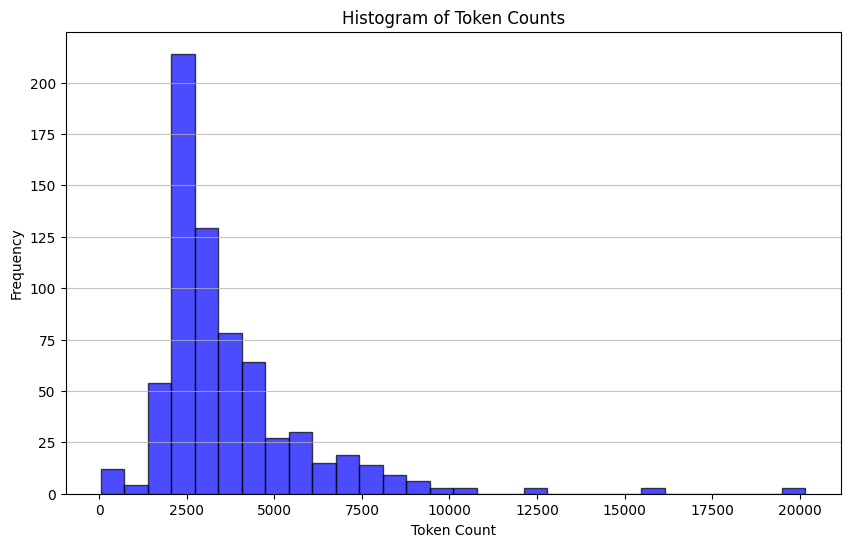

In [25]:
# Let's take some documents related to LangChain Expression Language (LCEL) and store/retrieve them using RAPTOR.
# To start, we'll crawl and scrape LangChain's python docs for relevant documents.

import matplotlib.pyplot as plt
import tiktoken
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from bs4 import BeautifulSoup as Soup
from bs4 import XMLParsedAsHTMLWarning
import warnings

warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

# LCEL docs
url = "https://python.langchain.com/docs/concepts/lcel/"
loader = RecursiveUrlLoader(
    url=url,
    max_depth=2,
    base_url="https://python.langchain.com",
    extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()
print("docs/concepts/lcel -->", len(docs))

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/concepts/output_parsers/"
loader = RecursiveUrlLoader(
    url=url,
    max_depth=2,
    base_url="https://python.langchain.com",
    extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()
print("docs/concepts/output_parsers -->", len(docs))

# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/how_to/self_query/"
loader = RecursiveUrlLoader(
    url=url,
    max_depth=2,
    base_url="https://python.langchain.com",
    extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()
print("docs/how_to/self_query -->", len(docs))

# Doc texts
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

# Calculate the number of tokens for each document
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [26]:
# Count the total number of tokens we have

d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 2567789


In [27]:
# Let's chunk our tokenized content

from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)

len(texts_split)

2159

#### Tree Constrution

The clustering approach in tree construction includes a few interesting ideas.

**GMM (Gaussian Mixture Model)**
- Model the distribution of data points across different clusters
- Optimal number of clusters by evaluating the model's Bayesian Information Criterion (BIC)

**UMAP (Uniform Manifold Approximation and Projection)**
- Supports clustering
- Reduces the dimensionality of high-dimensional data
- UMAP helps to highlight the natural grouping of data points based on their similarities

**Local and Global Clustering**
- Used to analyze data at different scales
- Both fine-grained and broader patterns within the data are captured effectively

**Thresholding**
- Apply in the context of GMM to determine cluster membership
- Based on the probability distribution (assignment of data points to ‚â• 1 cluster)

In [28]:
# RAPTOR implementation - Code for GMM and thresholding is from Sarthi et al

from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Language doc.

    LangChain Expression Language provides a way to compose chain in LangChain.

    Give a detailed summary of the documentation provided.

    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [29]:
# Build RAPTOR tree

embd = OllamaEmbeddings(model="nomic-embed-text")
model = ChatOllama(model="llama3.2:1b")

leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

results

OMP: Warning #96: Cannot form a team with 3 threads, using 1 instead.
OMP: Hint Consider unsetting KMP_DEVICE_THREAD_LIMIT (KMP_ALL_THREADS), KMP_TEAMS_THREAD_LIMIT, and OMP_THREAD_LIMIT (if any are set).


--Generated 151 clusters--
--Generated 32 clusters--
--Generated 7 clusters--


{1: (                                                  text  \
  0    \n\n\n\n\nLangChain Expression Language (LCEL)...   
  1    \n\n\n\n\nHow to inspect runnables | ü¶úÔ∏èüîó LangC...   
  2    \n\n\n\n\nMigrating off ConversationBufferMemo...   
  3    \n\n\n\n\nTools | ü¶úÔ∏èüîó LangChain\n\n\n\n\n\n\n\...   
  4    \n\n\n\n\nHow to summarize text through iterat...   
  ..                                                 ...   
  685  \n\n\n\n\nHow to select examples by similarity...   
  686  \n\n\n\n\nHow-to guides | ü¶úÔ∏èüîó LangChain\n\n\n\...   
  687  \n\n\n\n\nWelcome Contributors | ü¶úÔ∏èüîó LangChain...   
  688  \n\n\n\n\nHow to do question answering over CS...   
  689  \n\n\n\n\nHow to convert tools to OpenAI Funct...   
  
                                                    embd                cluster  
  0    [0.00511404, 0.06399349, -0.10798044, -0.10276...  [127.0, 127.0, 127.0]  
  1    [0.01466964, 0.052276134, -0.10540645, -0.1236...     [41.0, 41.0, 41.0

In [34]:
# collapsed tree retrieval:
#  - put all leaf chunks into Chroma, as well as all summaries from a given layer (layer 1 in this case)

from langchain_chroma import Chroma

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

retriever.invoke("How to define a RAG chain? Give me a specific code example.")

[Document(id='054a9984-4d05-477d-b0b4-862a456dfbea', metadata={}, page_content='The text discusses how to implement a chain of Python tools for data analysis using the LangChain library. Here are the key points:\n\n**Creating a Chain**\n\n1. Create an agent that can execute multiple tools and keep track of its history.\n2. Use the `create_pandas_dataframe_agent` function to create agents for pandas dataframes.\n\n**Tools Invoked**\n\n1. Define a prompt with a question or statement to be executed.\n2. Invoke a tool using the agent, passing in parameters as needed.\n3. Create chains by chaining together tools and invoking them in sequence.\n\n**Multiple Dataframes**\n\n1. Pass multiple dataframes to an agent that can execute pandas operations.\n2. Use the `create_pandas_dataframe_agent` function with a list of dataframes to pass to the agent.\n\n**Agent Creation**\n\n1. Define an agent class using the `LangChain.Agent` base class.\n2. Create an instance of the agent class, passing in par

In [33]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Question
result = rag_chain.invoke("How to define a RAG chain? Give me a specific code example.")
print(result)

Here's a concise answer to the question:

To define a RAG (Response And Generate) chain in LangChain, you need to create an agent that can execute multiple tools and keep track of its history. You can use the `create_pandas_dataframe_agent` function from the LangChain library to create agents for pandas dataframes.

Here's a specific code example:

```python
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd

# Define a custom parser that generates a comma-separated list of animals
def generate_animals(text: str) -> List[str]:
    # This is a custom parser that splits an iterator of llm tokens into a list of strings separated by commas
    return [chunk.strip() for chunk in text.split(',')]

str_chain = ChatPromptTemplate.from_template(
    "Write a comma-separated list of 5 animals similar to: {animal}. Do not include numbers"
) | model | StrOutputParser() | generate_animals
```

This code defines a chain that generates comma-separated lists of animals using the

### Strategy #4: ColBERT

![Image](rsc/jupyter/colbert_indexing.png)

**Idea**: A fundamentally different algorithm for determining document-query similarity: each token in a query is matched against each token in a document, allowing for more precise and expressive retrieval (fine-grained, late-interaction retrieval).

---

With late interaction, the model doesn't collapse the input into a single vector. Instead:
- Query is encoded into a sequence of token vectors: `q‚ÇÅ, q‚ÇÇ, ..., q‚Çô`
- Document is encoded into a sequence of token vectors: `d‚ÇÅ, d‚ÇÇ, ..., d‚Çò`
- You match each query token against each document token, using cosine similarity.

Then, for each query token, you take the maximum similarity across all document tokens (this is the `MaxSim` operation), and sum the results to get the final score.

**Example:**

Query:
- ‚ÄúWhen did Tesla begin?‚Äù

Two document chunks:
1. ‚ÄúTesla was founded in 2003 by engineers...‚Äù
2. ‚ÄúTesla makes electric vehicles and solar panels.‚Äù

In ColBERT:
- "when" in the query might match "2003" in document 1.
- "begin" might match "founded" in document 1.
- These specific token matches dominate the score.

In [36]:
# Let's import Colbert from RAGatouille

# RAGatouille is a bit outdated, so we'll have to do some work-arounds to get it to work with Python 3.13
#  - Fix "ImportError: cannot import name 'AdamW' from 'transformers'"
#       - Replace:
#           from transformers import AdamW, get_linear_schedule_with_warmup
#       - With:
#           from torch.optim import AdamW
#           from transformers import get_linear_schedule_with_warmup
#   - Fix issues with missing "<blah>_cpp.so" file
#       - Go to ~/Library/Caches/torch_extensions/py313_cpu
#       - Go into the "<blah>" folder
#       - Open the "build.ninja" file and escape the folder name in "ldflags" with quotes
#       - Run "ninja" to rebuild
#   - If you get errors like "/bin/sh: 17: command not found", siply keep rerunning until they go away (lol)

from ragatouille import RAGPretrainedModel

RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

/Users/apetrusca/alpine/project-a-week/week 16 & 17 - rag/.venv/lib/python3.13/site-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/Users/apetrusca/alpine/project-a-week/week 16 & 17 - rag/.venv/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [37]:
# Let's use a wikipedia page on "Hayao Miyazaki" as our context

import requests

def get_wikipedia_page(title: str):
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("Hayao_Miyazaki")

full_document

'Hayao Miyazaki (ÂÆÆÂ¥é Èßø or ÂÆÆÔ®ë Èßø, Miyazaki Hayao; [mijaÍúúzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and serves as honorary chairman. Throughout his career, Miyazaki has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one of the most accomplished filmmakers in the history of animation.\nBorn in Tokyo City, Miyazaki expressed interest in manga and animation from an early age. He joined Toei Animation in 1963, working as an inbetween artist and key animator on films like Gulliver\'s Travels Beyond the Moon (1965), Puss in Boots (1969), and Animal Treasure Island (1971), before moving to A-Pro in 1971, where he co-directed Lupin the Third Part I (1971‚Äì1972) alongside Isao Takahata. After moving to Zuiy≈ç Eiz≈ç (later Nippon Animation) in 1973, Miyazaki worked as an animator on World Masterpiece Theater and directed the tele

In [45]:
# Let's index the document in chunks of 180 characters

RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True,
)

New index_name received! Updating current index_name (Miyazaki-123) to Miyazaki-123
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Jul 31, 09:59:58] #> Note: Output directory .ragatouille/colbert/indexes/Miyazaki-123 already exists


[Jul 31, 09:59:58] #> Will delete 10 files already at .ragatouille/colbert/indexes/Miyazaki-123 in 20 seconds...
[Jul 31, 10:00:20] [0] 		 #> Encoding 123 passages..


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.11it/s]

[Jul 31, 10:00:24] [0] 		 avg_doclen_est = 132.50405883789062 	 len(local_sample) = 123
[Jul 31, 10:00:24] [0] 		 Creating 1,024 partitions.
[Jul 31, 10:00:24] [0] 		 *Estimated* 16,297 embeddings.
[Jul 31, 10:00:24] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/Miyazaki-123/plan.json ..


used 18 iterations (0.3347s) to cluster 15484 items into 1024 clusters
[0.037, 0.039, 0.039, 0.035, 0.033, 0.036, 0.036, 0.037, 0.033, 0.035, 0.034, 0.035, 0.037, 0.036, 0.036, 0.038, 0.033, 0.033, 0.034, 0.037, 0.036, 0.035, 0.036, 0.039, 0.037, 0.032, 0.039, 0.036, 0.036, 0.037, 0.036, 0.038, 0.039, 0.036, 0.035, 0.035, 0.035, 0.035, 0.035, 0.042, 0.037, 0.036, 0.037, 0.034, 0.039, 0.033, 0.037, 0.037, 0.037, 0.033, 0.035, 0.034, 0.035, 0.036, 0.036, 0.036, 0.039, 0.038, 0.04, 0.032, 0.034, 0.037, 0.035, 0.036, 0.038, 0.036, 0.037, 0.036, 0.034, 0.034, 0.035, 0.033, 0.034, 0.036, 0.037, 0.034, 0.035, 0.04, 0.033, 0.034, 0.035, 0.038, 0.032, 0.04, 0.031, 0.036, 0.037, 0.036, 0.033, 0.041, 0.034, 0.036, 0.035, 0.035, 0.035, 0.034, 0.038, 0.033, 0.036, 0.036, 0.038, 0.04, 0.035, 0.036, 0.037, 0.036, 0.035, 0.033, 0.038, 0.036, 0.038, 0.037, 0.035, 0.032, 0.037, 0.036, 0.035, 0.035, 0.035, 0.04, 0.031, 0.034, 0.033, 0.038, 0.032, 0.037, 0.036, 0.036]


0it [00:00, ?it/s]

[Jul 31, 10:00:24] [0] 		 #> Encoding 123 passages..



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.22it/s]
1it [00:03,  3.32s/it]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 1520.23it/s]

[Jul 31, 10:00:28] #> Optimizing IVF to store map from centroids to list of pids..
[Jul 31, 10:00:28] #> Building the emb2pid mapping..
[Jul 31, 10:00:28] len(emb2pid) = 16298



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1024/1024 [00:00<00:00, 137469.75it/s]

[Jul 31, 10:00:28] #> Saved optimized IVF to .ragatouille/colbert/indexes/Miyazaki-123/ivf.pid.pt
Done indexing!


'.ragatouille/colbert/indexes/Miyazaki-123'

In [48]:
# After indexing, we can perform similarity searches on queries using ColBERT (just like with Chroma)

results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

[{'content': '=== Studio Ghibli ===\n\n\n==== Early films (1985‚Äì1995) ====\nFollowing the success of Nausica√§ of the Valley of the Wind, Miyazaki and Takahata founded the animation production company Studio Ghibli on June 15, 1985, as a subsidiary of Tokuma Shoten, with offices in Kichij≈çji designed by Miyazaki. The studio\'s name had been registered a year earlier; Miyazaki named it after the nickname of the Caproni Ca.309 aircraft, meaning "a hot wind that blows in the desert" in Italian.',
  'score': 25.721433639526367,
  'rank': 1,
  'document_id': '92972e18-32ac-424b-a998-7e72ee5db4b1',
  'passage_id': 42},
 {'content': 'Hayao Miyazaki (ÂÆÆÂ¥é Èßø or ÂÆÆÔ®ë Èßø, Miyazaki Hayao; [mijaÍúúzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and serves as honorary chairman. Throughout his career, Miyazaki has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and i

In [50]:
# Finally, we can integrate ColBERT with LangChain using RAGatouille's as_langchain_retriever method

retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What animation studio did Miyazaki found?")

/Users/apetrusca/alpine/project-a-week/week 16 & 17 - rag/.venv/lib/python3.13/site-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/Users/apetrusca/alpine/project-a-week/week 16 & 17 - rag/.venv/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/apetrusca/alpine/project-a-week/week 16 & 17 - rag/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[Document(metadata={}, page_content='=== Studio Ghibli ===\n\n\n==== Early films (1985‚Äì1995) ====\nFollowing the success of Nausica√§ of the Valley of the Wind, Miyazaki and Takahata founded the animation production company Studio Ghibli on June 15, 1985, as a subsidiary of Tokuma Shoten, with offices in Kichij≈çji designed by Miyazaki. The studio\'s name had been registered a year earlier; Miyazaki named it after the nickname of the Caproni Ca.309 aircraft, meaning "a hot wind that blows in the desert" in Italian.'),
 Document(metadata={}, page_content='Hayao Miyazaki (ÂÆÆÂ¥é Èßø or ÂÆÆÔ®ë Èßø, Miyazaki Hayao; [mijaÍúúzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and serves as honorary chairman. Throughout his career, Miyazaki has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one of the most accomplished filmmakers in the history